In [1]:
# Extract Features using DenseNet201
import os
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201  # Changed to DenseNet201

# Base model for feature extraction
conv_base = DenseNet201(weights='imagenet', include_top=False)

train_dir = 'dataset/Freshwater Fish Disease Aquaculture in south asia/Train'
validation_dir  = 'dataset/Freshwater Fish Disease Aquaculture in south asia/Test'

def extract_features(file_name, directory, sample_count='all', target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)
    h5_file = h5py.File(file_name, 'w')

    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    samples_processed = 0
    batch_number = 0
    if sample_count == 'all':
        sample_count = generator.n

    print_size = True
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)

        if print_size:
            print_size = False
            print('Features shape', features_batch.shape)

        samples_processed += inputs_batch.shape[0]
        h5_file.create_dataset('features-'+ str(batch_number), data=features_batch)
        h5_file.create_dataset('labels-'+str(batch_number), data=labels_batch)
        batch_number += 1
        print("Batch:%d Sample:%d\r" % (batch_number,samples_processed), end="")

        if samples_processed >= sample_count:
            break

    h5_file.create_dataset('batches', data=batch_number)
    h5_file.close()
    return

# Extract features
extract_features('train_densenet201.h5', train_dir, sample_count='all', batch_size=100, target_size=(224,224))
extract_features('validation_densenet201.h5', validation_dir, sample_count='all', batch_size=100, target_size=(224,224))





Found 1747 images belonging to 7 classes.
4/4 [==============================] - 18s 3s/step
Features shape (100, 7, 7, 1920)
2/2 [==============================] - 9s 4s/step
Found 697 images belonging to 7 classes.
4/4 [==============================] - 18s 4s/step
Features shape (100, 7, 7, 1920)
4/4 [==============================] - 17s 4s/step
Batch:7 Sample:697

In [2]:
from __future__ import print_function
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers

# -------------------------
# Generator to read HDF5 features
# -------------------------
def features_from_file(path, ctx):
    h5f = h5py.File(path, 'r')
    batch_count = h5f['batches'][()]
    print(ctx, 'batches:', batch_count)

    def generator():
        while True:
            for batch_id in range(0, batch_count):
                X = h5f['features-' + str(batch_id)]
                y = h5f['labels-' + str(batch_id)]
                yield X, y

    return batch_count, generator()

train_steps_per_epoch, train_generator = features_from_file('train_densenet201.h5', 'train')
validation_steps, validation_data = features_from_file('validation_densenet201.h5', 'validation')

np.random.seed(7)

# -------------------------
# Classifier on top of DenseNet201 features
# -------------------------
inputs = Input(shape=(7, 7, 1920))  # DenseNet201 feature map size
x = Conv2D(64, (1, 1), activation='relu', padding='same')(inputs)
x = Dropout(0.5)(x)
x = Flatten()(x)
outputs = Dense(7, activation='softmax')(x)  # 7 classes

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['acc'])

model.summary()

# -------------------------
# Callbacks
# -------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.5, patience=5, min_lr=0.00005)
]

# -------------------------
# Training
# -------------------------
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=validation_data,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=callbacks
)

# -------------------------
# Save the model
# -------------------------
model.save("model_2.hdf5")


train batches: 18
validation batches: 7
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 1920)]      0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 64)          122944    
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 7)                 21959     
                                                                 
Total params: 144903 (566.03 KB)
Trainable params: 144903 (566.03 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________

C:\Users\atchaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


C:\Users\atchaya\AppData\Local\Temp\ipykernel_13384\2582839609.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', color='red', label='Validation Accuracy')
C:\Users\atchaya\AppData\Local\Temp\ipykernel_13384\2582839609.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='red', label='Validation Loss')


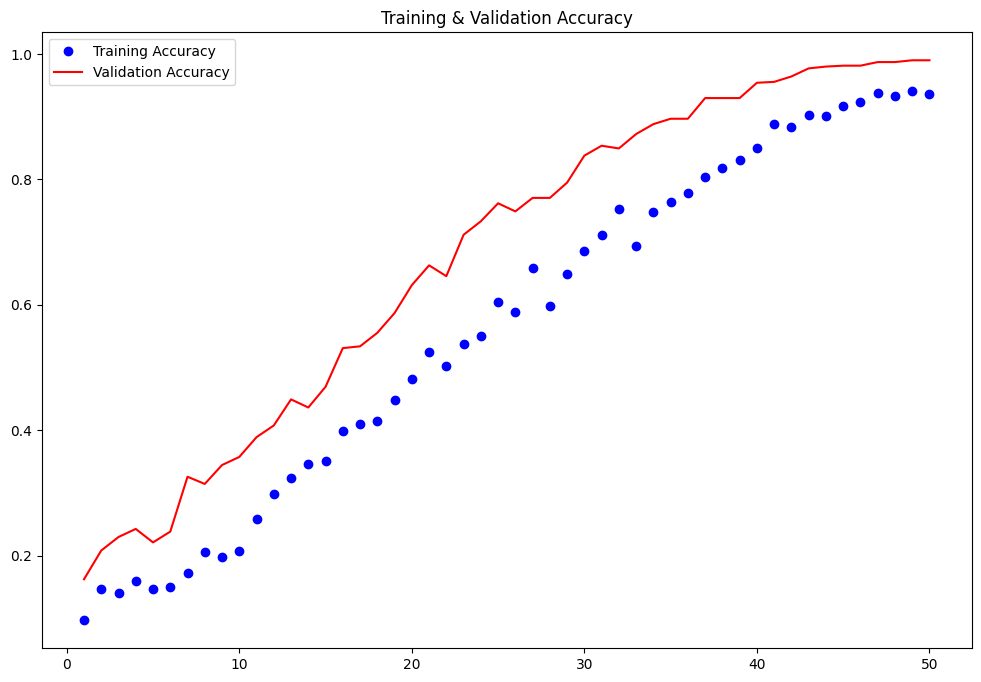

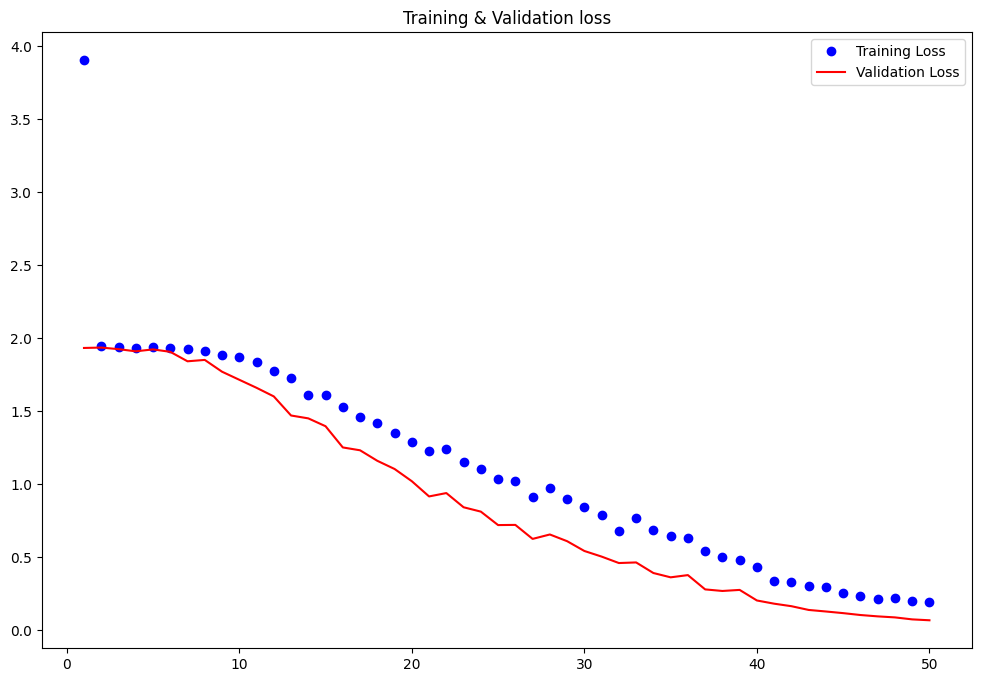

In [3]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,8))
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', color='red', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.figure(figsize=(12,8))
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', color='red', label='Validation Loss')
    plt.title('Training & Validation loss')
    plt.legend()

    plt.show()
    return acc, val_acc, loss, val_loss


acc, val_acc, loss, val_loss = plot_history(history)